In [95]:
from os import walk
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import random

In [236]:
root_dir = './images_background/'
categories = [[folder, os.listdir(root_dir + folder)] for folder in os.listdir(root_dir)  if not folder.startswith('.') ]

In [248]:
class OmniglotDataset(Dataset):
    def __init__(self, categories, root_dir, setSize, transform=None):
        self.categories = categories
        self.root_dir = root_dir
        self.transform = transform
        self.setSize = setSize
    def __len__(self):
        return self.setSize
    def __getitem__(self, idx):
        img1 = None
        img2 = None
        label = None
        if idx % 2 == 0: # select the same character for both images
            category = random.choice(categories)
            character = random.choice(category[1])
            imgDir = root_dir + category[0] + '/' + character
            img1Name = random.choice(os.listdir(imgDir))
            img2Name = random.choice(os.listdir(imgDir))
            img1 = Image.open(imgDir + '/' + img1Name)
            img2 = Image.open(imgDir + '/' + img2Name)
            label = 1.0
        else: # select a different character for both images
            category1, category2 = random.choice(categories), random.choice(categories)
            category1, category2 = random.choice(categories), random.choice(categories)
            character1, character2 = random.choice(category1[1]), random.choice(category2[1])
            imgDir1, imgDir2 = root_dir + category1[0] + '/' + character1, root_dir + category2[0] + '/' + character2
            img1Name = random.choice(os.listdir(imgDir1))
            img2Name = random.choice(os.listdir(imgDir2))
            while img1Name == img2Name:
                img2Name = random.choice(os.listdir(imgDir2))
            label = 0.0
            img1 = Image.open(imgDir1 + '/' + img1Name)
            img2 = Image.open(imgDir2 + '/' + img2Name)
#         plt.imshow(img1)
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return img1, img2, torch.from_numpy(np.array([label], dtype=np.float32))          


In [249]:
dataSize = 6000 # self-defined dataset size
TRAIN_PCT = 0.8 # percentage of entire dataset for training
train_size = int(dataSize * TRAIN_PCT)
val_size = dataSize - train_size

IMG_SIZE = 32
transformations = transforms.Compose(
    [transforms.ToTensor()]) 

omniglotDataset = OmniglotDataset(categories, root_dir, 6000, transformations)
train_set, val_set = random_split(omniglotDataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, num_workers=0)

In [250]:
import torch.nn as nn
import torch.nn.functional as F

torch.Size([4, 1, 105, 105])


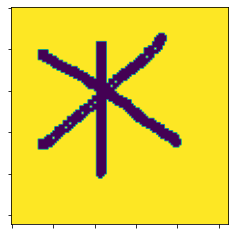

In [251]:
for img1, img2, label in train_loader:
    print(img1.shape)
    plt.imshow(img1[0][0])
    break

In [252]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Conv2d(input_channels, output_channels, kernel_size)
        self.conv1 = nn.Conv2d(1, 64, 10) 
        self.conv2 = nn.Conv2d(64, 128, 7)  
        self.conv3 = nn.Conv2d(128, 128, 4)
        self.conv4 = nn.Conv2d(128, 256, 4)
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fcOut = nn.Linear(4096, 1)
        self.sigmoid = nn.Sigmoid()
    
    def convs(self, x):

        # out_dim = in_dim - kernel_size + 1  
        #1, 105, 105
        x = F.relu(self.conv1(x))
        # 64, 96, 96
        x = F.max_pool2d(x, (2,2))
        # 64, 48, 48
        x = F.relu(self.conv2(x))
        # 128, 42, 42
        x = F.max_pool2d(x, (2,2))
        # 128, 21, 21
        x = F.relu(self.conv3(x))
        # 128, 18, 18
        x = F.max_pool2d(x, (2,2))
        # 128, 9, 9
        x = F.relu(self.conv4(x))
        # 256, 6, 6
        return x
    
    def forward(self, x1, x2):
        x1 = self.convs(x1)
        x1 = x1.view(-1, 256 * 6 * 6)
        x1 = self.sigmoid(self.fc1(x1))
        x2 = self.convs(x2)
        x2 = x2.view(-1, 256 * 6 * 6)
        x2 = self.sigmoid(self.fc1(x2))
        x = torch.abs(x1 - x2)
        x = self.sigmoid(self.fcOut(x))
        return x

In [253]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
siameseBaseLine = Net()
siameseBaseLine = siameseBaseLine.to(device)

In [254]:
def save_checkpoint(save_path, model, optimizer, val_loss):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_loss': val_loss}

    torch.save(state_dict, save_path)

    print(f'Model saved to ==> {save_path}')

def load_checkpoint(model, optimizer):
    save_path = f'siameseNet.pt'
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_loss = state_dict['val_loss']
    print(f'Model loaded from <== {save_path}')
    
    return val_loss

In [255]:
def train(model, train_loader, val_loader, num_epochs, criterion, save_name):
    best_val_loss = float("Inf") 
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for img1, img2, labels in train_loader:
            model.train()
            
            # Forward
            img1 = img1.to(device)
            img2 = img2.to(device)
            outputs = model(img1, img2)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        val_running_loss = 0.0
        with torch.no_grad():
            model.eval()
            for img1, img2, labels in val_loader:
                img1 = img1.to(device)
                img2 = img2.to(device)
                outputs = net(img1, img2)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.4f}'
            .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
        if average_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_checkpoint(save_name, net, optimizer, best_val_loss)
    
    print("Finished Training")    

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(siameseBaseLine.parameters(), lr = 0.001)
num_epochs = 10
criterion = nn.BCELoss()
save_path = 'siameseNet.pt'
train_losses, val_losses = train(siameseBaseLine, train_loader, val_loader, num_epochs, criterion, save_path)